In [22]:
# base modules
import os
import sys
import copy
import logging
import math
from collections import defaultdict

# for manipulating data
import numpy as np
import pandas as pd
import dill
import scipy

# for Machine Learning
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.inspection import permutation_importance
from scipy.cluster import hierarchy

# for visualization
from IPython.display import display
from matplotlib import pyplot as plt
# plotly
# seaborn
# altair

In [23]:
path_to_repo = os.path.dirname(os.getcwd())
sys.path.insert(0, os.path.join(path_to_repo, 'src'))

In [24]:
from mlpcourse.utils import *

In [25]:
def rmse(y_gold, y_pred):
    return math.sqrt(((y_gold - y_pred)**2).mean())


def print_score(m, X_train, y_train, X_valid, y_valid):
    print(f'RMSE on train set: {rmse(y_train, m.predict(X_train)):.4f}')
    print(f'RMSE on valid set: {rmse(y_valid, m.predict(X_valid)):.4f}')
    print(f'R^2 on train set: {m.score(X_train, y_train):.4f}')
    print(f'R^2 on valid set: {m.score(X_valid, y_valid):.4f}')
    return

In [26]:
path_to_repo = os.path.dirname(os.getcwd())

path_to_bulldozers = os.path.join(path_to_repo, "data", "bulldozers", "")

path_to_dataset = os.path.join(
    path_to_repo, "data", 'bulldozers', 'bulldozers-raw')
print(path_to_dataset)

df_raw = pd.read_feather(path_to_dataset)

df, y, nas = proc_df(df_raw, 'SalePrice')


def split_vals(df, n):
    return df[:n].copy(), df[n:].copy()


n_total = len(df)
n_valid = 12000
n_train = n_total - n_valid

X_train, X_valid = split_vals(df, n_train)
y_train, y_valid = split_vals(y, n_train)

/Users/jiaokan/Workshop/Machine Learning in Practice/data/bulldozers/bulldozers-raw


In [27]:
def rf_feat_importance(model, df):
    feat_importance = pd.DataFrame({
        'cols': df.columns,
        'imp': model.feature_importances_,
    }).sort_values('imp', ascending=False)
    return feat_importance

# 训练Random Forest模型
model = RandomForestRegressor(n_estimators=50, min_samples_split=10, max_features=0.5,
                              n_jobs=-1, random_state=42, bootstrap=True, oob_score=True, max_samples=0.75)
model.fit(X_train, y_train)

# 输出模型性能
print_score(model, X_train, y_train, X_valid, y_valid)

RMSE on train set: 0.1324
RMSE on valid set: 0.2302
R^2 on train set: 0.9634
R^2 on valid set: 0.9054


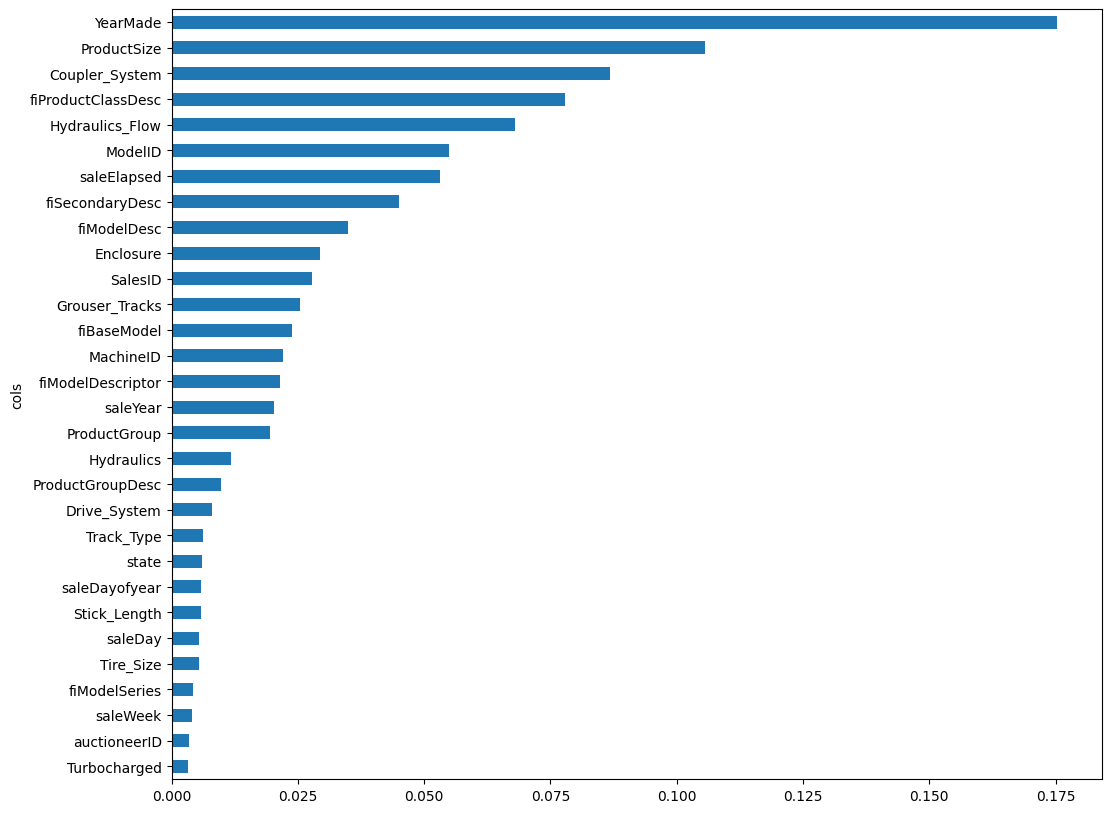

In [28]:
feat_importance = rf_feat_importance(model, X_train)
feat_importance[:30].plot('cols', 'imp', 'barh', figsize=(12,10), legend=False).invert_yaxis()

/var/folders/sm/4h6m8zs55_d20f8gnjq32vw40000gn/T/ipykernel_6878/2955221340.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_valid.columns[sorted_idx])


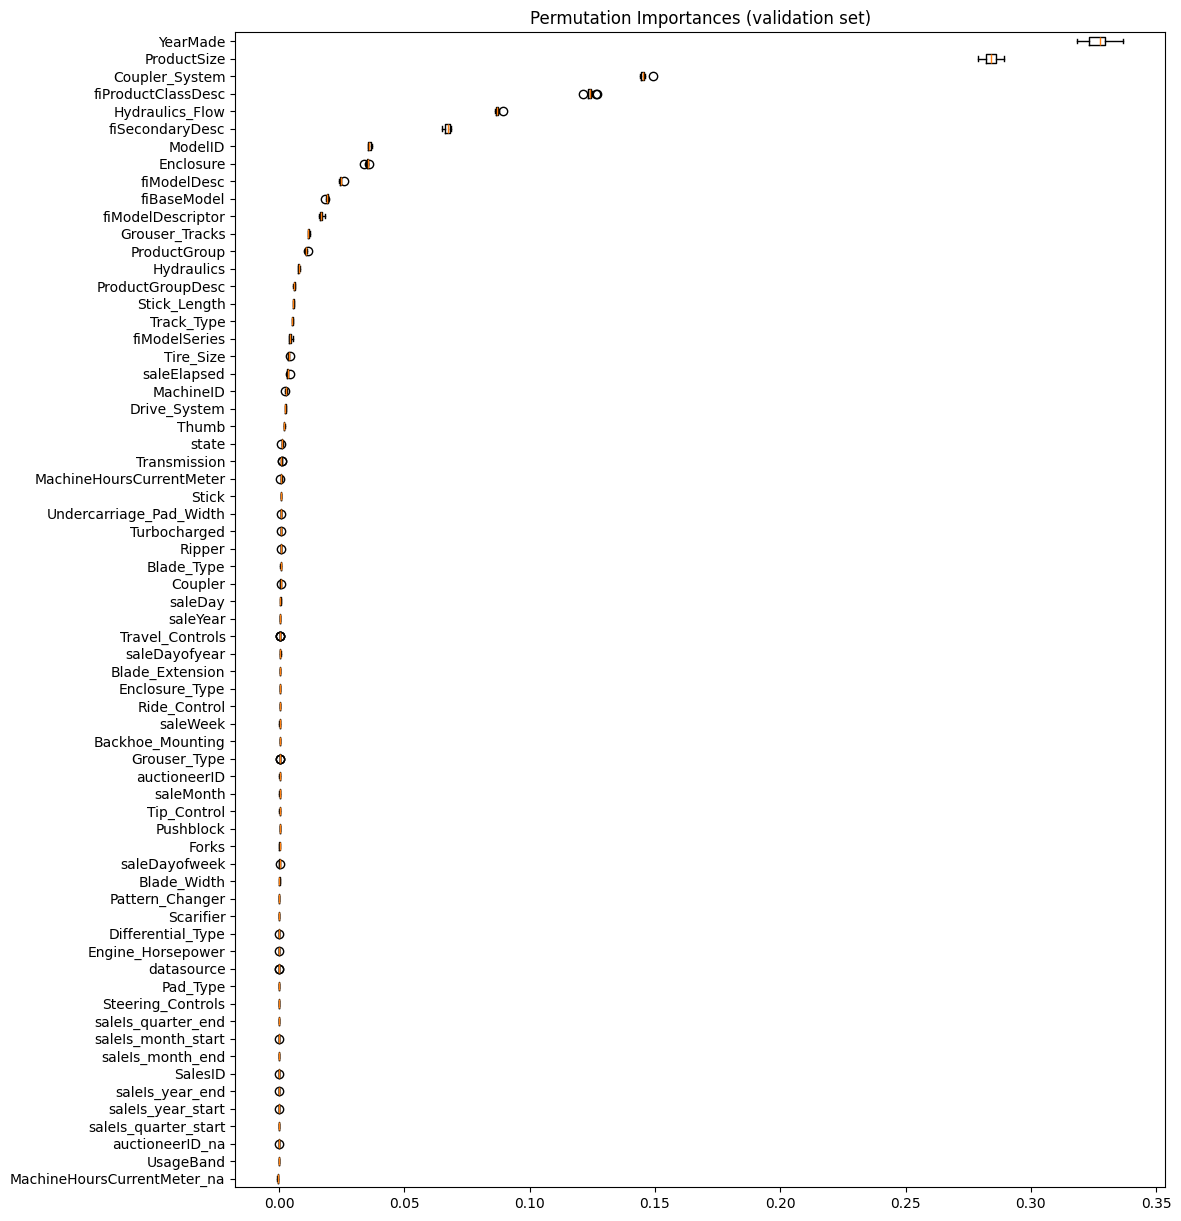

In [29]:
# 基于排列重要性的特征选择
result = permutation_importance(model, X_valid, y_valid, n_repeats=10, random_state=42, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

# 绘制排列重要性图
fig, ax = plt.subplots(figsize=(12, 15))
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_valid.columns[sorted_idx])
ax.set_title("Permutation Importances (validation set)")
plt.show()

RMSE on train set: 0.1384
RMSE on valid set: 0.2351
R^2 on train set: 0.9600
R^2 on valid set: 0.9012


/var/folders/sm/4h6m8zs55_d20f8gnjq32vw40000gn/T/ipykernel_6878/1781379084.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(result.importances[sorted_idx].T, vert=False,


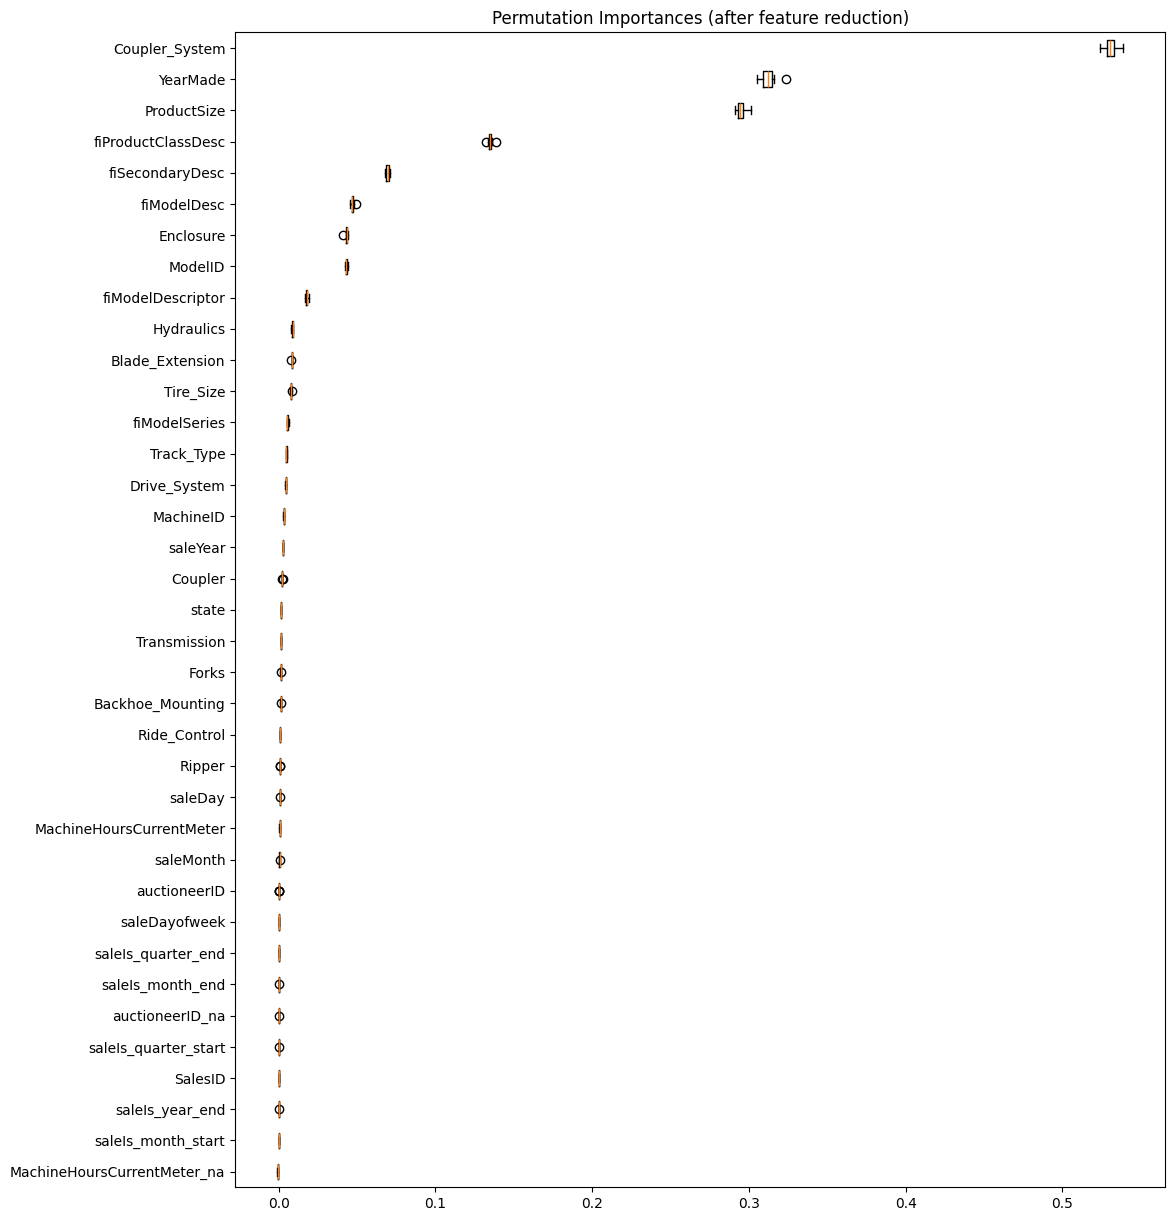

In [30]:
# 去除冗余特征（特征相关性）
def remove_redundant_features(df, threshold=0.2):
    # 去除常量列
    df = df.loc[:, (df != df.iloc[0]).any()]
    # 计算 spearman 相关性矩阵
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    # 检查是否有 NaN 值
    if np.any(np.isnan(corr)):
        raise ValueError(
            "Correlation matrix contains NaN values. Please check your data.")
    # 将相关性矩阵转换为距离矩阵（注意：相关性矩阵应为对称矩阵）
    corr_condensed = hierarchy.distance.squareform(1 - corr)
    # 执行层次聚类
    corr_linkage = hierarchy.linkage(corr_condensed, method='average')
    # 获取每个簇的特征索引
    cluster_ids = hierarchy.fcluster(
        corr_linkage, threshold, criterion='distance')
    # 构建簇ID到特征索引的映射
    cluster_id_to_feature_ids = defaultdict(list)
    for idx, cluster_id in enumerate(cluster_ids):
        cluster_id_to_feature_ids[cluster_id].append(idx)
    # 保留每个簇中第一个特征
    selected_features = [df.columns[v[0]]
                         for v in cluster_id_to_feature_ids.values()]
    return df[selected_features]


# 去除相关性高的特征并重新训练模型
df_reduced = remove_redundant_features(df)
X_train_reduced, X_valid_reduced = split_vals(df_reduced, n_train)

model.fit(X_train_reduced, y_train)
print_score(model, X_train_reduced, y_train, X_valid_reduced, y_valid)

# 最终排列重要性
result = permutation_importance(
    model, X_valid_reduced, y_valid, n_repeats=10, random_state=42, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(12, 15))
ax.boxplot(result.importances[sorted_idx].T, vert=False,
           labels=X_valid_reduced.columns[sorted_idx])
ax.set_title("Permutation Importances (after feature reduction)")
plt.show()

In [31]:
result.importances_mean, np.percentile(result.importances_mean, 40)

(array([ 3.33066907e-17,  3.23162305e-03,  4.31403434e-02,  3.20327724e-04,
         3.12507255e-01,  6.77443813e-04,  4.71767250e-02,  6.93644212e-02,
         5.65862531e-03,  1.78530291e-02,  2.94957983e-01,  1.35094242e-01,
         1.58239751e-03,  4.59533672e-03,  4.31786398e-02,  1.18852148e-03,
         9.92776369e-04,  1.49761026e-03,  8.36747038e-03,  8.73090792e-03,
         9.18215170e-04,  7.84321653e-03,  2.24872200e-03,  5.30714516e-01,
         4.81890465e-03,  1.18550195e-03,  2.82538618e-03,  5.27415205e-04,
         8.11662554e-04,  5.21816756e-05,  1.11650441e-05, -2.99666823e-06,
         1.17893781e-05,  2.21509274e-07,  1.11022302e-17,  3.57486976e-07,
        -6.54174233e-04]),
 np.float64(0.0010698666030138227))

In [32]:
bool_filter = result.importances_mean > np.percentile(
    result.importances_mean, 45)
to_keep = df_reduced.columns[bool_filter]

df_keep = df_reduced[to_keep].copy()

X_train_keep, X_valid_keep = split_vals(df_keep, n_train)
y_train, y_valid = split_vals(y, n_train)

df_keep

,MachineID,ModelID,YearMade,fiModelDesc,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,Drive_System,Enclosure,Transmission,Blade_Extension,Hydraulics,Tire_Size,Coupler,Coupler_System,Track_Type,saleYear
0,999089,3157,2004,950,41,0,0,0,59,1,0,3,0,0,1,17,3,0,0,2006
1,117657,77,1996,1725,55,98,0,4,62,33,0,3,0,0,1,12,3,0,0,2004
2,434808,7009,2001,331,0,0,0,0,39,32,0,6,0,0,4,0,3,1,0,2004
3,1026470,332,2001,3674,0,45,0,6,8,44,0,3,0,0,1,0,3,0,0,2011
4,1057373,17311,2007,4208,0,0,0,0,40,32,0,1,0,0,4,0,3,1,0,2009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401120,1840702,21439,2005,657,106,63,0,5,17,20,0,1,0,0,4,0,3,0,2,2011
401121,1830472,21439,2005,657,106,63,0,5,17,20,0,1,0,0,12,0,3,0,2,2011
401122,1887659,21439,2005,657,106,63,0,5,17,20,0,1,0,0,4,0,3,0,2,2011
401123,1903570,21435,2005,483,106,0,0,5,13,9,0,1,0,0,12,0,3,0,2,2011


In [33]:
model = RandomForestRegressor(
    n_estimators = 60,
    max_depth = 45,
    min_samples_split = 10,
    max_features = 0.51, # default = 'auto'/None
    n_jobs = -1, 
    random_state = 42,
    
    bootstrap = True,
    oob_score = True, # default = False, 
    max_samples = 0.75, # default = None,
)

%time model.fit(X_train_keep, y_train)
print_score(model, X_train_keep, y_train, X_valid_keep, y_valid)

CPU times: user 53.2 s, sys: 958 ms, total: 54.1 s
Wall time: 10.4 s
RMSE on train set: 0.1530
RMSE on valid set: 0.2238
R^2 on train set: 0.9511
R^2 on valid set: 0.9105
